# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Загрузим необходимые библиотеки, а также посмотрим на данные и их структуру.

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

import lightgbm as lgb


In [2]:
df = pd.read_csv(r'C:\Users\dkiro\Desktop\проект\autos.csv', parse_dates = [0, 12, 15])
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Посмотрим, в каких переменных находятся пропуски, а также % пропусков от общего числа наблюдений в датасете

In [4]:
missings = pd.DataFrame(df.isna().sum())
missings['%'] = round(missings/len(df) * 100, 2)
missings

,0,%
DateCrawled,0,0.00
Price,0,0.00
VehicleType,37490,10.58
RegistrationYear,0,0.00
Gearbox,19833,5.60
Power,0,0.00
Model,19705,5.56
Kilometer,0,0.00
RegistrationMonth,0,0.00
FuelType,32895,9.28


Пропуски находятся в 5 переменных, причем все они категориальные. Количество пропусков варьируется от 5 до 20%. Удалять строки мы не будем, поскольку в этом случае мы потеряем слишком много информации. Заполнять пропуски наиболее часто встречающимся значением тоже рискованно, поскольку может быть сильный перекос в сторону этого значения в переменной. Заполним пропуски в этих переменных простым 'unknown' и будем рассматривать это как отдельную категорию

In [5]:
df.columns = df.columns.str.lower() # приводим названия столбцов в нижний регистр для удобства
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [6]:
missing_vars = [
    'vehicletype',
    'gearbox',
    'model',
    'fueltype',
    'notrepaired',
] 

for var in missing_vars:
    df[var] = df[var].fillna('unknown')

In [7]:
df.isna().sum()

datecrawled          0
price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
kilometer            0
registrationmonth    0
fueltype             0
brand                0
notrepaired          0
datecreated          0
numberofpictures     0
postalcode           0
lastseen             0
dtype: int64

In [8]:
df = df.drop('numberofpictures', axis = 1) # неинформативный столбец, одно нулевое значение


Посмотрим теперь, есть ли выбросы в количественных переменных **price, power, kilometer**.

In [9]:
def hist_box(var):
    
    """
    Функция строит совместные боксплоты и гистограммы
    для выбранных переменных. Переменные передаются в
    функцию как строки.
    
    """
    
    sns.set(style="ticks")

    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.85, 1.85)})

    sns.boxplot(df[var], ax=ax_box)
    sns.distplot(df[var], ax=ax_hist)

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

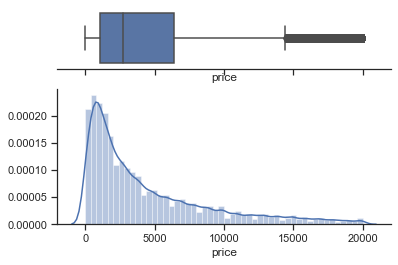

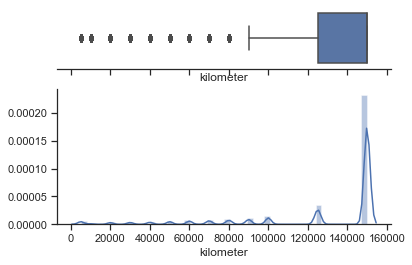

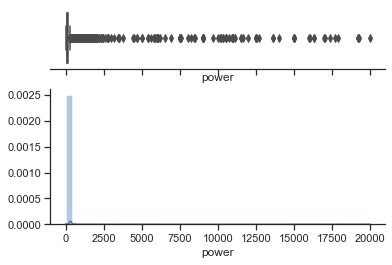

In [10]:
hist_box('price')
hist_box('kilometer')
hist_box('power')


Очевидно, что во всех трех переменных есть существенное количество выбросов. Если мы будем удалять их по межквартильному правилу, то потеряем слишком много данных. Поэтому просто ограничим сверху переменную **price**, а переменную **kilometer** снизу таким образом, чтобы убрать самые очевидные выбросы и при этом потерять не больше 10% данных. С переменной **power** разберемся чуть позже. 

In [11]:
NUM_OF_OBS = 354369

# Ограничения сверху и снизу подбирались эмпирически с учетом гистограмм и боксплотов переменных

df = df[df['price'] <= 18000]
df = df[df['kilometer'] >= 50000]
perc = round((1-len(df)/NUM_OF_OBS) * 100, 2)
print(f'Удалено {perc}% от изначального количества наблюдений')

Удалено 6.96% от изначального количества наблюдений


Мы удалили почти 7% выбросов из датасета. Теперь рассмотрим переменную **power** и несколько ее квантилей

In [12]:
for i in np.linspace(0.75, 1, 7):
    print(f'Quantile {round(i, 2)}  | ', df.power.quantile(i))
    print()
    

df = df[df['power'] < 225]
print(f'Количество записей в новой таблице равно {len(df)}')

Quantile 0.75  |  143.0

Quantile 0.79  |  150.0

Quantile 0.83  |  163.0

Quantile 0.88  |  170.0

Quantile 0.92  |  192.0

Quantile 0.96  |  224.0

Quantile 1.0  |  20000.0

Количество записей в новой таблице равно 317332


Отсечем все значения переменной после 0.96-го квантиля, поскольку там уже точно содержатся только выбросы.

In [13]:
deleted_ratio = 1-len(df) / NUM_OF_OBS 

print(f'Всего из таблицы удалено {round(deleted_ratio, 3) * 100}%')

Всего из таблицы удалено 10.5%


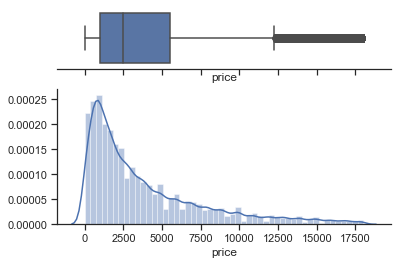

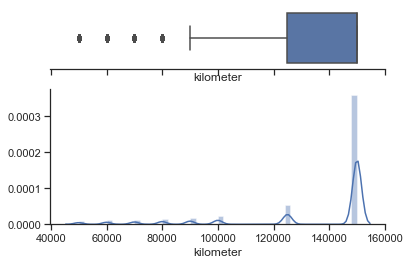

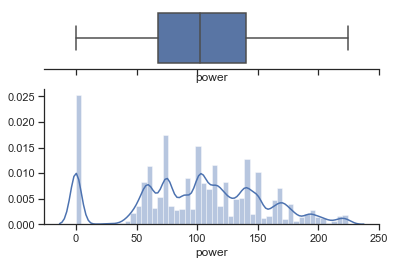

In [14]:
hist_box('price')
hist_box('kilometer')
hist_box('power')


Ситуация с выбросами значительно улучшилась для переменной **power** - все выбросы были удалены. Также уменьшилось количество выбросов и  для остальных двух переменных, **price и kilometer**.

Теперь стандартизируем количественные переменные, чтобы они были одной размерности, а для категориальных переменных проведем процедуру OHE (one-hot encoding). Также разобьем данные на тренировочную и тестовую выборки. 

In [15]:
categ = df.dtypes[df.dtypes == 'object'].index
numeric = df.dtypes[df.dtypes == 'int64'].index

In [16]:
for var in categ:
    df[var] = df[var].astype('category')

In [17]:
df_train, df_test = train_test_split(df, test_size = 0.25, random_state = 123)

In [18]:
scaler = StandardScaler()
scaler.fit(df_train[numeric])
pd.options.mode.chained_assignment = None

df_train[numeric] = scaler.transform(df_train[numeric])
df_test[numeric] = scaler.transform(df_test[numeric])

In [19]:
# Столбцы с датами также не особо информативны, поэтому не будем включать их в признаки
X_train = df_train.drop(['price', 'datecrawled', 'lastseen', 'datecreated'], axis=1)
X_test =  df_test.drop(['price', 'datecrawled', 'lastseen', 'datecreated'], axis=1)

y_train, y_test = df_train.price, df_test.price

In [20]:
X_train_copy, X_test_copy  = X_train.copy(), X_test.copy() 

In [21]:
X_train = pd.get_dummies(X_train, columns = categ, drop_first = True)
X_test = pd.get_dummies( X_test, columns = categ, drop_first = True)

In [22]:
print(X_train.shape)
print(X_test.shape)
print(X_train_copy.shape)
print(X_test_copy.shape)

(237999, 312)
(79333, 312)
(237999, 11)
(79333, 11)


## Обучение и анализ моделей

Обучим несколько моделей машинного обучения: линейную регрессию, дерево решений и градиентный бустинг.

In [23]:
start = time.time()
lr = LinearRegression()
lr.fit(X_train, y_train)
end = time.time()

fit_time_lr = round(end - start, 2)

print("Время обучения линейной регрессии: " , round(fit_time_lr, 2)) 

Время обучения линейной регрессии:  9.56


In [24]:
start = time.time()
pred_lr = lr.predict(X_test)
end = time.time()

pred_lr_time = round(end - start, 2)
rmse_lr_test = round(mse(y_test, pred_lr) ** 0.5, 2)

print("Время предсказания линейной регрессии: " , round(pred_lr_time, 2)) 
print("RMSE на тестовой выборке составляет:", rmse_lr_test )

Время предсказания линейной регрессии:  0.23
RMSE на тестовой выборке составляет: 0.65




Далее обучим дерево решений и будем изменять параметр максимальной глубины дерева от 3 до 11 с шагом 2. Применим процедуру кросс-валидации.

In [25]:
dtr = DecisionTreeRegressor(random_state = 123)

parametrs = {
    'max_depth': range (3,13, 2), 
}
grid = GridSearchCV(dtr,
                    parametrs,
                    scoring = 'neg_mean_squared_error',
                    cv=5)

In [26]:
start_time = time.time()
grid.fit(X_train, y_train)
end_time = time.time()

fit_time_dtr = end_time - start_time

print('Время обучения дерева решений составляет', round(fit_time_dtr,2))

Время обучения дерева решений составляет 112.0


In [27]:
rmse_dtr = np.sqrt(-grid.best_score_)
print(f'Oценка качества дерева решений путем кросс-валидации: {round(rmse_dtr, 3)}')
print("Лучшие параметры модели:", grid.best_params_)

Oценка качества дерева решений путем кросс-валидации: 0.476
Лучшие параметры модели: {'max_depth': 11}


In [28]:
start_time = time.time()
pred_dtr = grid.predict(X_test)
end_time = time.time()

pred_dtr_time = end_time - start_time 
rmse_dtr_test = round(mse(y_test, pred_dtr) **0.5, 2)

print('Время предсказания дерева решений:', round(pred_dtr_time, 2))
print("RMSE на тестовой выборке составляет:", rmse_dtr_test )

Время предсказания дерева решений: 0.19
RMSE на тестовой выборке составляет: 0.48



И наконец обучим модель градиентного бустинга с помощью библиотеки lightGBM.

In [29]:
gb = lgb.LGBMRegressor(random_state = 123)


params = {
    'max_depth': [7, 11],
    'learning_rate': [0.01, 0.1],
}

grid_gb = GridSearchCV(gb,
                       params,
                       scoring = 'neg_mean_squared_error',
                       cv=5)

In [30]:
start = time.time()
grid_gb.fit(X_train_copy, y_train)
end = time.time()

fit_time_gb = round(end - start, 2)

print('Время обучения модели градиентного бустинга:', fit_time_gb)

Время обучения модели градиентного бустинга: 24.85


In [31]:
rmse_gb = np.sqrt(-grid_gb.best_score_)
print('Oценка качества градиентного бустинга путем кросс-валидации:' , round(rmse_gb, 3))
print("Лучшие параметры модели:", grid_gb.best_params_)

Oценка качества градиентного бустинга путем кросс-валидации: 0.396
Лучшие параметры модели: {'learning_rate': 0.1, 'max_depth': 11}


Посмотрим на значение rmse на тестовой выборке.

In [32]:
start = time.time()
predictions_gb = grid_gb.predict(X_test_copy)
end = time.time()

pred_gb_time = round(end - start, 2)

print('Время предсказания модели градиентного бустинга:', pred_gb_time)

Время предсказания модели градиентного бустинга: 0.26


In [33]:
test_rmse_gb = np.sqrt(mse(y_test,predictions_gb))

print("RSME на тестовой выборке равно", round(test_rmse_gb, 3))

RSME на тестовой выборке равно 0.398


In [36]:
overall_tab = pd.DataFrame(
    {
        'fit_time': [fit_time_lr, fit_time_dtr, fit_time_gb],
        'prediction_time': [pred_lr_time, pred_dtr_time, pred_gb_time],
        'RMSE_test': [rmse_lr_test, rmse_dtr_test, test_rmse_gb],
    },
    index=['linear regression', 'decision tree', 'gradient boosting'])

overall_tab

,fit_time,prediction_time,RMSE_test
linear regression,9.560000,0.23000,0.650000
decision tree,112.002949,0.19198,0.480000
gradient boosting,24.850000,0.26000,0.398418


## Вывод

Цель проекта - построение качественной модели, которая могла бы прогнозировать рыночную стоимость автомобиля. Для начала мы сделали предобработку исходных данных, заполнив пропуски и почистив датасет от выбросов. Кроме этого мы стандартизировали данные и добавили дамми-столбцы для категориальных переменных. 

Мы проверили 3 модели: линейную регрессию, дерево решений и градиентный бустинг. Наиболее быстрой в обучении оказалась модель линейной регрессии: время подгонки - 9.5 секунд, а наиболее медленной оказалась модель решающего дерева: время подгонки составило 112 секунд. Время предсказания наибольшее (0.19 сек.) у модели градиентного бустинга, наименьшее (0.13 сек) - у линейной регрессии. Однако наименьший RMSE на тестовой выборке показала модель градиентного бустинга, а наименьшее, наоборот - линейная регрессия (0.39 против 0.65). Таким образом, с учетом скорости подгонки модели и метрики RMSE модель градиентного бустинга является наилучшей. Итоговые показатели качества моделей можно найти в таблице overall_tab.
